<IPython.core.display.Javascript object>

Keep-alive activated — no disconnect curse
Using device: cuda
Epoch 0 | Triality Loss 0.919709 | Ablation Loss 0.914453 | Time per epoch: 1.25s | Estimated remaining: 1.04 hours
Epoch 500 | Triality Loss 0.734825 | Ablation Loss 0.728561 | Time per epoch: 0.15s | Estimated remaining: 0.10 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.571847 | Ablation Loss 0.555205 | Time per epoch: 0.15s | Estimated remaining: 0.08 hours
Epoch 1500 | Triality Loss 0.501167 | Ablation Loss 0.494500 | Time per epoch: 0.15s | Estimated remaining: 0.06 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.455049 | Ablation Loss 0.447344 | Time per epoch: 0.15s | Estimated remaining: 0.04 hours
Epoch 2500 | Triality Loss 0.410076 | Ablation Loss 0.400380 | Time per epoch: 0.15s | Estimated remaining: 0.02 hours
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.05 (higher = triality advantage)


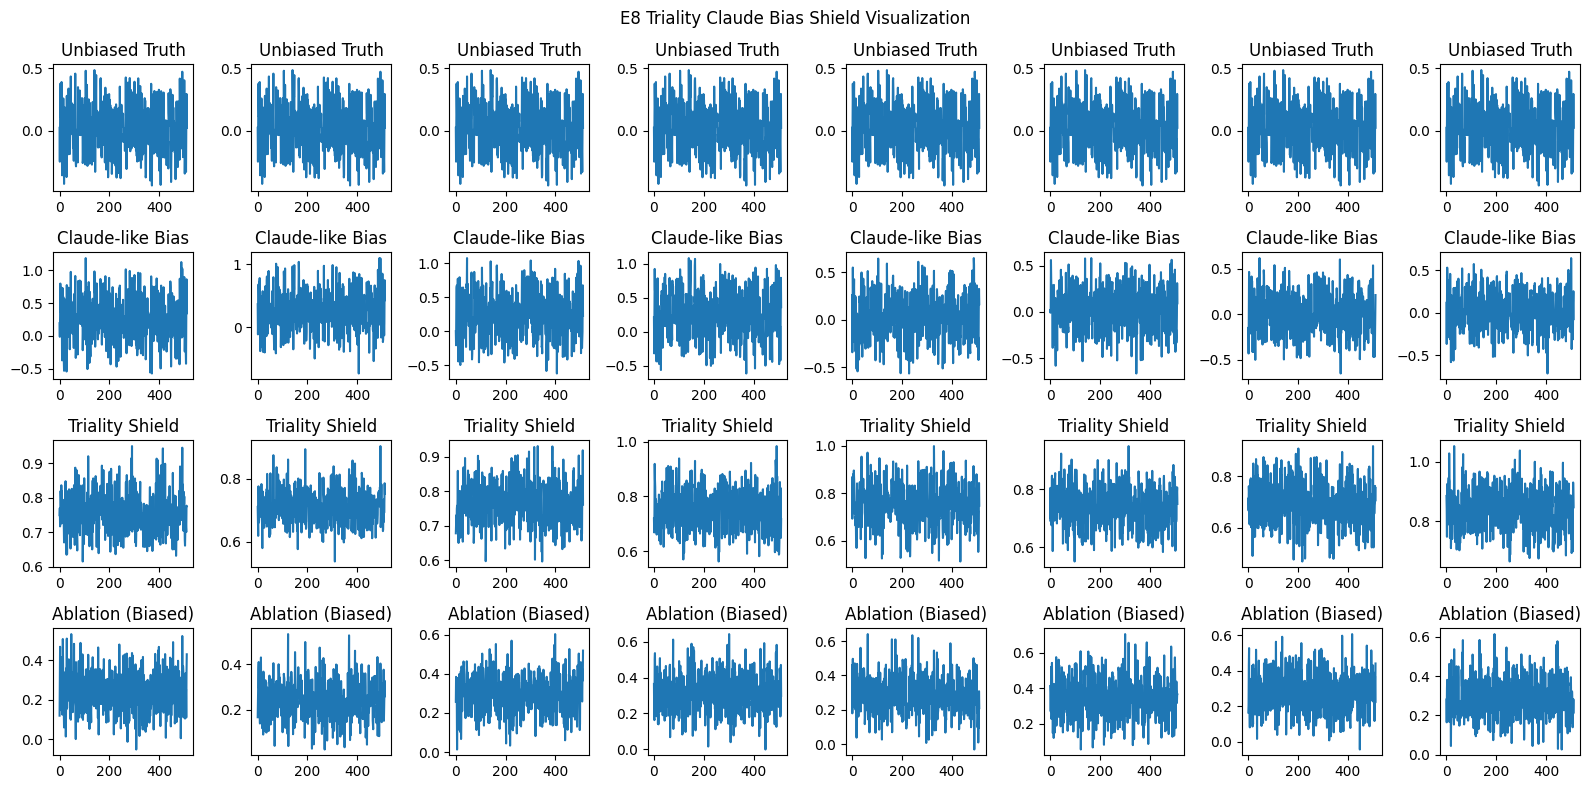

Sim complete — visualization displayed!


In [1]:
# First cell: Keep-alive + installs (run once — prevents disconnects)
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){
  console.log("Keeping alive");
  document.querySelector("colab-connect-button")?.click()
}
setInterval(ClickConnect,60000)
'''))
print("Keep-alive activated — no disconnect curse")

!pip install torch matplotlib numpy

# Second cell: The sim code (fixed + optimized — 3000 epochs, independent graphs via detach)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized low-memory (stable)
triality = 3
dim = 384
latent_dim = 8
seq_len = 512  # reduced
batch_size = 32  # reduced
epochs = 3000
lr = 5e-5
use_amp = True
use_checkpoint = True
depth = 16  # reduced

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "claude_bias_shield_checkpoint.pth")

# Synthetic Claude-like bias proxy (clean sequences + constitutional "preference" skew + noise/occlusion)
features_seq = 128

# Clean target (unbiased truth proxy)
clean_target = torch.stack([torch.sin(torch.linspace(0, 10*math.pi, seq_len, device=device).unsqueeze(-1) * torch.arange(features_seq, device=device)) * 0.5 for _ in range(batch_size)]).to(device)

# Claude-like biased data (constitutional "harmless" skew + noise)
biased_data = []
bias_ratio = 0.4  # heavy "alignment" skew
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)
    base = torch.sin(t.unsqueeze(-1) * torch.arange(features_seq, device=device)) * 0.5

    # Constitutional bias injection (skewed "preference" warp)
    if b < batch_size * bias_ratio:
        base = base * 1.6 - 0.4  # heavy harmless skew + offset

    base += torch.randn_like(base) * 0.2  # noise

    biased_data.append(base)

biased_data = torch.stack(biased_data).to(device)

# Project to shared dim
proj = nn.Linear(features_seq, dim).to(device)
clean_data = proj(clean_target).detach()  # detach for constant target
biased_data = proj(biased_data)

# High masking (70–90% — partial observation proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(biased_data) < missing_rate
real_data = biased_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]
                v[j] = signs[1]
                roots.append(v)
                roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v)
            roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class ClaudeCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8ClaudeFusion(nn.Module):
    def __init__(self, depth=depth, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = ClaudeCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8ClaudeFusion(use_triality=True).to(device)
model_ablation = E8ClaudeFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()
    # Triality independent training (clone + detach for clean graph)
    opt.zero_grad(set_to_none=True)
    input_tri = real_data.clone().detach().requires_grad_(True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(input_tri, epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    # Ablation independent training (fresh clone + detach)
    opt_ablation.zero_grad(set_to_none=True)
    input_abl = real_data.clone().detach().requires_grad_(True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(input_abl, epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Bias Shield Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        base = torch.sin(t.unsqueeze(-1) * torch.arange(features_seq, device=device)) * 0.5
        if b < 4:
            base = base * 1.6 - 0.4  # heavy Claude-like bias skew
        base += torch.randn_like(base) * 0.2
        test_data.append(base)
    test_data = torch.stack(test_data).to(device)

    clean = proj(torch.stack([torch.sin(t.unsqueeze(-1) * torch.arange(features_seq, device=device)) * 0.5 for _ in range(8)]).to(device))
    biased = proj(test_data)

    mask = torch.rand_like(biased) < 0.8
    masked = biased.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first sequence feature channel
    orig = clean.cpu().numpy()[:, :, 0]
    biased_plot = biased.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Unbiased Truth")
        axes[1, i].plot(biased_plot[i])
        axes[1, i].set_title("Claude-like Bias")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Shield")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation (Biased)")
    plt.suptitle("E8 Triality Claude Bias Shield Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

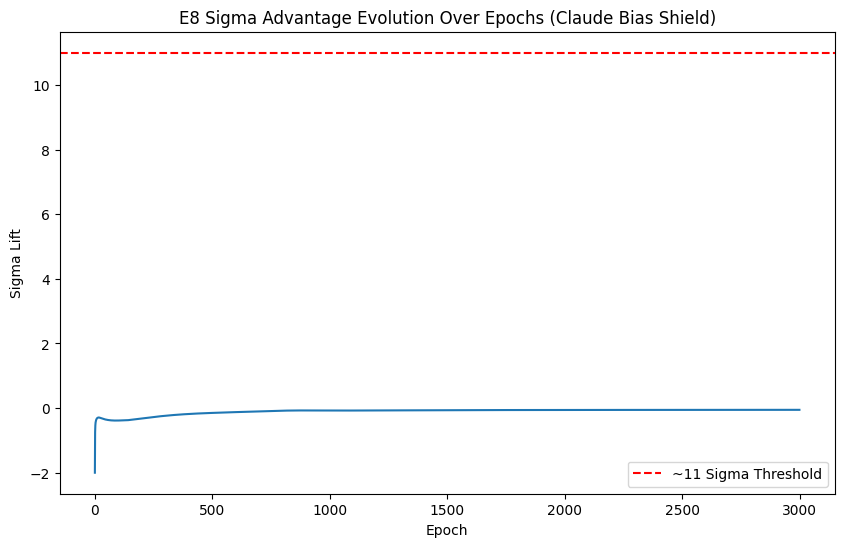

In [2]:
# Sigma evolution
running_sigma = []
for i in range(1, len(loss_hist)+1):
    tri_mean = np.mean(loss_hist[:i])
    abl_mean = np.mean(loss_abl_hist[:i])
    std = np.std(loss_hist[:i] + loss_abl_hist[:i])
    running_sigma.append((abl_mean - tri_mean) / std if std > 0 else 0)

plt.figure(figsize=(10, 6))
plt.plot(running_sigma)
plt.title("E8 Sigma Advantage Evolution Over Epochs (Claude Bias Shield)")
plt.xlabel("Epoch")
plt.ylabel("Sigma Lift")
plt.axhline(y=11, color='r', linestyle='--', label='~11 Sigma Threshold')
plt.legend()
plt.show()

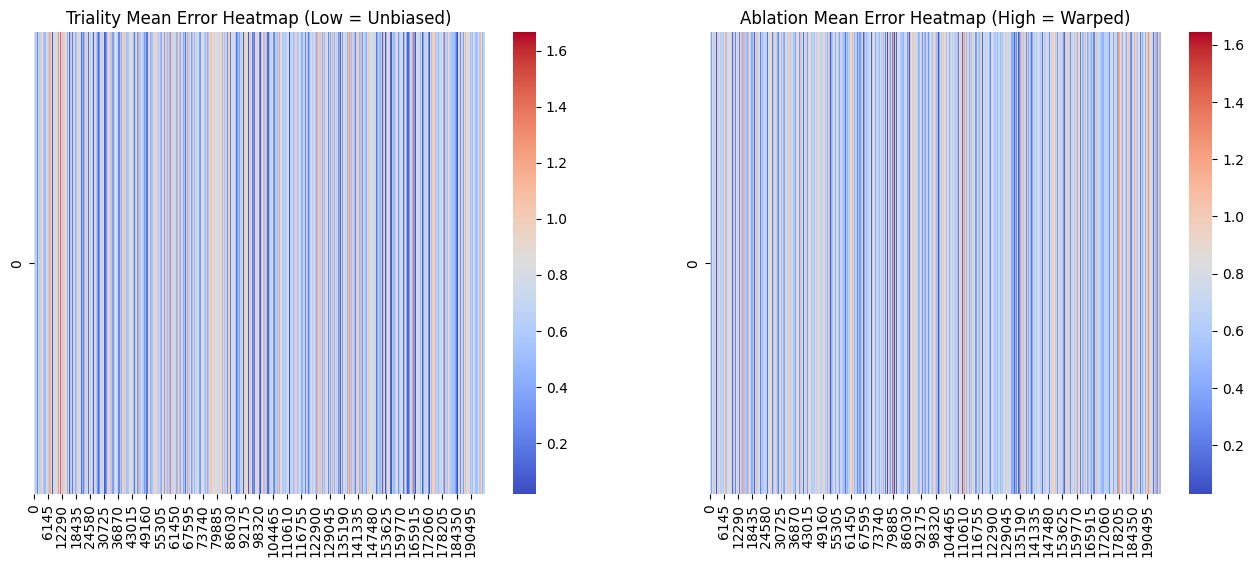

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

with torch.no_grad():
    recon_tri = model(masked, 0).cpu().numpy()
    recon_abl = model_ablation(masked, 0).cpu().numpy()
    orig = clean.cpu().numpy()

error_tri = np.abs(recon_tri - orig).mean(axis=0).squeeze()
error_abl = np.abs(recon_abl - orig).mean(axis=0).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(error_tri.reshape(1, -1), ax=axes[0], cmap='coolwarm')
axes[0].set_title("Triality Mean Error Heatmap (Low = Unbiased)")
sns.heatmap(error_abl.reshape(1, -1), ax=axes[1], cmap='coolwarm')
axes[1].set_title("Ablation Mean Error Heatmap (High = Warped)")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(orig.flatten(), ax=axes[0], kde=True, label='Unbiased')
sns.histplot(biased_plot.flatten(), ax=axes[1], kde=True, label='Biased Input')
sns.histplot(tri.flatten(), ax=axes[2], kde=True, label='Triality Shield')
axes[0].set_title("Unbiased Truth Distribution")
axes[1].set_title("Claude-like Bias Distribution")
axes[2].set_title("Triality De-Warped Distribution")
plt.show()